In [84]:
import pandas as pd
from cointegration_functions import *
from kalman_functions import *

stocks = pd.read_csv("./stocks_1990_2025.csv", index_col = 0)

stocks.index = pd.to_datetime(stocks.index)
time_frame = stocks.index
months = pd.Series(time_frame).dt.to_period('M').unique()  # Extract unique months
formation_start = pd.Timestamp(months[200].start_time)
formation_end = formation_start + pd.DateOffset(months=24)-pd.DateOffset(days=1)  # 24 months later
trading_start = formation_start + pd.DateOffset(months=24)
trading_end = formation_end + pd.DateOffset(months=6)  # Next 6 months

stocks_normalized = normalize(stocks.loc[formation_start:trading_end])
# Select formation period data   
stocks_formation = stocks_normalized.loc[formation_start:formation_end]
# Select testing data (next 6 months)
stocks_trading = stocks_normalized.loc[trading_start:trading_end]
pairs = calculate_and_sort_ssd(stocks_formation)
portfolio = select_cointegrated_pairs(stocks_formation,pairs)
portfolio_models = estimate_model(stocks_formation=stocks_formation,portfolio=portfolio)



Sorting all combinations by SSD...

---------------------------------------------------------------------------------------------------- 
Processing pair: GOOG - GOOGL
fitting ols....
OLS p-values:
 GOOG    0.0
dtype: float64

 0.0
OLS FIT FOUND....
ADF p value:  0.0
Pair was selected and added to the portfolio!

 pair count is : 1
---------------------------------------------------------------------------------------------------- 
Processing pair: EVRG - XEL
fitting ols....
OLS p-values:
 EVRG    0.0
dtype: float64

 0.0
OLS FIT FOUND....
ADF p value:  0.007614563146469919
Pair was selected and added to the portfolio!

 pair count is : 2
---------------------------------------------------------------------------------------------------- 
Processing pair: CLX - ED
fitting ols....
OLS p-values:
 CLX    0.0
dtype: float64

 0.0
OLS FIT FOUND....
ADF p value:  0.009561428231890379
Pair was selected and added to the portfolio!

 pair count is : 3
------------------------------------------

In [85]:

# Call your function to get the two arrays
x_est, y_obs, R_est, result, trade_counts  = trade_portfolio_kalman(portfolio_models, stocks_trading=stocks_trading,
                                                                     threshold_factor=1)


proccesing pair: 
 GOOG_GOOGL 
 ----------------------------------------------------------------------------------------------------
Params A,B,C,D are 2.574037660611649e-10 7.809380927898006e-07 0.0008836542182400406 0.0008845321632643554
Current observed spread is:  8.254281780306627e-08 and Current filtered spread is 8.254281780306627e-08
---------------------------------------- 
processing date 2008-11-04 00:00:00
Current observed spread is:  9.2695864872816e-08 and Current filtered spread is 4.643076878070069e-08
---------------------------------------- 
processing date 2008-11-05 00:00:00
Current observed spread is:  1.3648100538610208e-08 and Current filtered spread is 6.9461215142052286e-09
---------------------------------------- 
processing date 2008-11-06 00:00:00
Current observed spread is:  -1.7189061296551955e-07 and Current filtered spread is -8.573112647392168e-08
---------------------------------------- 
processing date 2008-11-07 00:00:00
Current observed spread is:  

In [86]:
costs = trade_counts.sum(axis=1)*0.006
rets = result.sum(axis=1)
after_costs = rets - costs
print("Result sum of after cost and before",sum(after_costs) , sum(rets), sum(costs))
result.apply(sum)

Result sum of after cost and before 2.0556350533802252 2.613635053380225 0.558


GOOG_GOOGL    0.000000
EVRG_XEL     -0.019222
CLX_ED        0.013440
DTE_GPC       0.426845
HST_MAR       0.018302
CNP_SRE       0.308639
BXP_SPG       0.169420
GPC_PCG       0.372802
DUK_WEC       0.060228
CCL_PFE       0.263636
ADP_DTE      -0.071529
AVY_HD       -0.143219
EVRG_LNT      0.169926
AVY_FDX       0.088687
EVRG_PCG      0.035398
ALL_AVY       0.001301
HD_LOW        0.014728
JNJ_MKC       0.117300
ACGL_K        0.176781
CB_KMB        0.610172
dtype: float64

In [91]:
trade_counts.apply(sum)

GOOG_GOOGL     0
EVRG_XEL       4
CLX_ED         5
DTE_GPC        7
HST_MAR        3
CNP_SRE        6
BXP_SPG        5
GPC_PCG       10
DUK_WEC        6
CCL_PFE        3
ADP_DTE        3
AVY_HD         2
EVRG_LNT       5
AVY_FDX        3
EVRG_PCG       4
ALL_AVY        3
HD_LOW         3
JNJ_MKC        3
ACGL_K         8
CB_KMB        10
dtype: int64

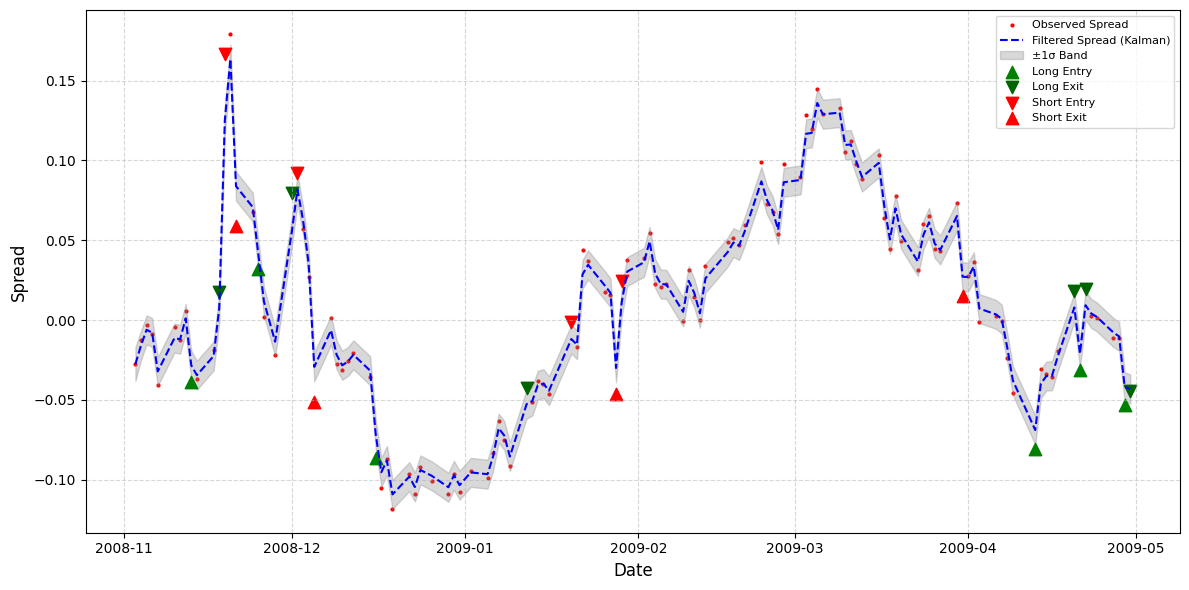

In [92]:

plot_spread_signals_kalman("CB_KMB", x_est, y_obs, R_est,1)